In [216]:
import pandas as pd
import numpy as np

import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri

import statsmodels.formula.api as smf
import statsmodels.api as sm

import patsy

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

import os

from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input


import glmnet_python
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPredict import glmnetPredict

from cvglmnet import cvglmnet
from cvglmnetPredict import cvglmnetPredict

# 10.9.1 A Single Layer Network on the Hitters Data

The lab starts off by reading baseball player data from Hitters.csv and then randomly generating a list of numbers, called testids.  Testids are indices referring to rows in our testing dataset.  This list of numbers will separate the training data from the testing data when creating a model and assessing its performance.

In order to reproduce the results from the part of the lab in Python, I need to get the same list of testids in Python.  Unfortunately, there is no easy way to generate them in Python, however I can generate them in R and send them over to Python quite easily by using the [rpy2](https://rpy2.github.io/) module.

After I have the testids, I adjust the index of the baseball data to start at 1.  Because R starts indexing at 1, but Python starts at 0, adjusting the indices ensures that I'm using the correct rows that were used in the lab.  Failure to do so would lead to different results.

In [217]:
data = robjects.r("""
library(ISLR2)
n <- nrow(na.omit(Hitters))
set.seed(13)
ntest <- trunc(n / 3)
testid <- sample(1:n, ntest)
""")

Gitters = pd.read_csv('../../../datasets/Hitters.csv')

Gitters = Gitters.dropna()

# R starts indexing at 1, Python starts indexing at 0, this is to make sure the indices of the dataframes match


Gitters = Gitters.set_index(keys=np.arange(1, len(Gitters) + 1)) 

testid = np.sort(np.array(data))
test_mask = Gitters.index.isin(testid)

In R, many models can be built using the `forumla=` parameter, which behaves like this:

`formula = OutputFeature ~ InputFeature1 + InputFeature 2 + ...`

When you want to use all of the features in your dataset to predict/approximate the `OutputFeature`, there's a special syntax that simplies the process, where a `.` can be used to refer to all columns in the dataset that aren't your `OutputFeature`:

`formula = OutputFeature ~ .`

To fit the model in R, we can use the `lm()` function, but in Python there's the `OLS()` function from the statsmodels library.  Unfortunately, `OLS()` doesn't have the same special syntax to refer to many columns at once and each individual column has to be explcitly typed into `formula=`.

To simplify this process, I define a function `formula_from_cols()`, which will build the formulas for me.

In [218]:
def formula_from_cols(df, y, use_target, remove_intercept):
    formula_string = ' + '.join([col for col in df.columns if not col==y])
    if use_target == True:
        formula_string = y + ' ~ ' + formula_string
    if remove_intercept == True:
        formula_string = formula_string + ' - 1'
    return formula_string

In [219]:
formula_string = formula_from_cols(Gitters, 'Salary', use_target = True, remove_intercept=False)

lmodel = smf.ols(formula=formula_string, data = sm.add_constant(Gitters[~test_mask]))

lfit = lmodel.fit()

lpred = lfit.predict(Gitters[test_mask])

np.mean(abs(lpred - Gitters[test_mask]['Salary']))

254.6686528837497

Using this linear regression model to predict a baseball player's salary, the mean absolute error (MAE) is the same as the lab from the textbook.

Next, the lab goes on to fit a lasso regresson model on the same dataset, however the dataset needs some preprocessing beforehand.  In R, the lab uses the `model.matrix()` function to create what's called a [design matrix](https://www.statlect.com/glossary/design-matrix), but in Python we can use the [Patsy](https://patsy.readthedocs.io/en/latest/) library and the `dmatrix()` function.  

Among other things, Patsy will take categorical variables, such as `League` or `Division` from the baseball dataset and convert them into dummy variables.  We can also use Patsy to scale the dataset, however we need to set `ddof=1` so that Patsy divides by the square root of the unbiased estimator of the variance as opposed to the maximum likelihood estimate.

In [220]:
formula_string = formula_from_cols(Gitters, 'Salary', use_target = False, remove_intercept=True)

x = patsy.dmatrix(formula_like = 'AtBat + Hits + HmRun + Runs + RBI + Walks + Years + CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + League + Division + PutOuts + Assists + Errors + NewLeague - 1', data = Gitters)

x_scale = patsy.scale(x, ddof=1)

y = np.array(Gitters['Salary'])

In [221]:
x.design_info.column_names

['League[A]',
 'League[N]',
 'Division[T.W]',
 'NewLeague[T.N]',
 'AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors']

In [222]:
X_train = x_scale[~test_mask]
X_test = x_scale[test_mask]

y_train = Gitters[~test_mask]['Salary']
y_test = Gitters[test_mask]['Salary']

cvfit = cvglmnet(x = x_scale[~test_mask], y = y[~test_mask], ptype='mae')

cpred = cvglmnetPredict(cvfit, newx = x_scale[test_mask], s = 'lambda_min')

In [223]:
np.mean(abs(y[test_mask] - cpred))

427.2936419595149

I'm getting a much higher MAE than the ISLR textbook does (they get ~253) and I'm not entirely sure why.  As far as I can tell, the inputs, `x_scale` and `y` are the same as in the textbook, however the predictions (`cpred`) are different, leading to a different MAE.  I need to investigate further.

Lastly, the lab uses the `keras` library in R to create a neural network to predict Salary from the baseball dataset.  The neural model has one hidden layer with 50 units that activate based on the `relu` activation function, then a dropout layer with a dropout rate of 40%, and finally an output layer with a single output, the predicted salary.

The neural network will treat each row of our design matrix as an input vector.  Because the design matrix has 20 columns, each input vectors will have 20 features, one for each column.  Each feature of the input vectors will be fed into the 50 units in the first hidden layer.  The output of this first hidden layer will be either 0 or 1 based on the `relu` function, where an output of 1 means that the neuron "fired".  These outputs are then fed into the next layer, the dropout layer, where 40% of the outputs will be excluded and before being fed into the last layer, the output layer.

In [224]:
modnn = keras.Sequential(
    [
            layers.Dense(units = 50, activation='relu'),
            layers.Dropout(rate=0.4),
            layers.Dense(units=1)
    ]
)

After defining the neural network model, we compile and fit it to our dataset, then view the model's performance over time.

In [225]:
modnn.compile(
    loss=tf.keras.losses.MeanSquaredError(), 
    optimizer='rmsprop', 
    metrics=tf.keras.losses.MeanAbsoluteError()
)

In [226]:
history = modnn.fit(X_train, 
                    y_train, 
                    epochs=1500, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    verbose=0)

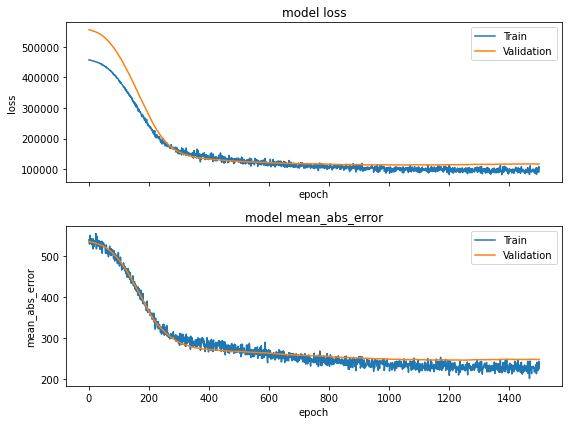

In [227]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['mean_absolute_error'])
ax[1].plot(history.history['val_mean_absolute_error'])
ax[1].set_title('model mean_abs_error')
ax[1].set_ylabel('mean_abs_error')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])

plt.tight_layout();

In [228]:
npred = modnn.predict(X_test)

3/3 [==============================] - 0s 2ms/step


In [229]:
np.mean(abs(y_test - npred.flatten()))

253.24266167862115

The graph above shows that after about 800 training epochs, the validation MAE settles down and remains constant roughly at 250.  This is close to what the book gets (they get 257.43) and is close to what our linear regression model in the first part of this lab got (254.6687).  

Because the dropout layer drops at random, I don't think it's possible to reproduce the results from the lab in R exactly, however the MAE is close enough and the plots above are quite similar to the plots in R, such that I'm confident I've reproduced the lab's results as much as possible.

# 10.9.2 A Multilayer Network on the MNIST Digit Data

In [15]:
(x_train, g_train), (x_test, g_test) = keras.datasets.mnist.load_data()

In [16]:
x_train.shape

(60000, 28, 28)

In [17]:
x_test.shape

(10000, 28, 28)

In [18]:
x_train = np.reshape(x_train, newshape=(x_train.shape[0], 784))
x_test = np.reshape(x_test, newshape=(x_test.shape[0], 784))

In [19]:
# y_train = pd.get_dummies(g_train)
# y_test = pd.get_dummies(g_test)

y_train = keras.utils.to_categorical(g_train, num_classes=10)
y_test = keras.utils.to_categorical(g_test, num_classes=10)

In [20]:
x_train = x_train / 255
x_test = x_test / 255

In [21]:
modelnn = keras.Sequential(
    [
            layers.Dense(units=256, activation='relu'),
            layers.Dropout(rate=0.4),
            layers.Dense(units=128, activation='relu'),
            layers.Dropout(rate=0.3),
            layers.Dense(units=10, activation='softmax')
    ]
)

In [22]:
modelnn.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics='accuracy'
)

In [23]:
history = modelnn.fit(x_train, 
                      y_train, 
                      epochs=30, 
                      batch_size=128, 
                      validation_split=0.2,
                      verbose=0)

In [24]:
modelnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


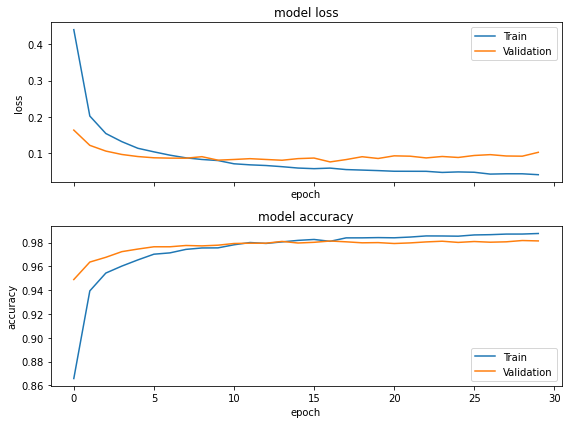

In [25]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])

plt.tight_layout();

In [26]:
y_proba = modelnn.predict(x_test)
y_pred_classes = np.argmax(y_proba, axis=1)

313/313 [==============================] - 0s 1ms/step


In [27]:
modelnn_acc = np.mean(y_pred_classes == g_test)
modelnn_acc

0.9819

## Multiclass Logistic Regression

In [28]:
modellr = keras.models.Sequential(
    [
            layers.Dense(units=10, activation='softmax')
    ]
)

In [29]:
modellr.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics='accuracy')

In [30]:
modellr.fit(x_train, 
            y_train, 
            epochs=30, 
            batch_size=128, 
            validation_split=0.2,
            verbose=0)

In [31]:
y_proba = modellr.predict(x_test)
y_pred_classes = np.argmax(y_proba, axis=1)

313/313 [==============================] - 0s 915us/step


In [32]:
modellr_acc = np.mean(y_pred_classes == g_test)
modellr_acc

0.9265

# 10.9.3 Convolutional Neural Networks

In [33]:
(x_train, g_train), (x_test, g_test) = keras.datasets.cifar100.load_data()

x_train.shape

(50000, 32, 32, 3)

In [34]:
x_train[0, :, :, 0].min(), x_train[0, :, :, 0].max()

(13, 255)

In [35]:
x_train = x_train / 255
x_test = x_test / 255
y_train = keras.utils.to_categorical(g_train, num_classes=100)

y_train.shape

(50000, 100)

Some code below borrowed from: https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html#cifar100-single

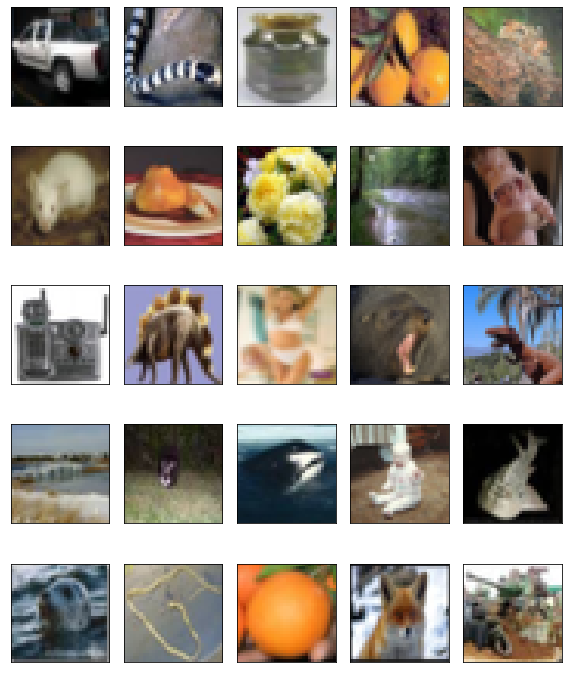

In [36]:
rows, columns = 5,5
rand_idx = np.random.randint(0, 50000, rows * columns)
rand_images = x_train[rand_idx]
fig = plt.figure(figsize=(8,10))
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(rand_images[i-1])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [37]:
model = keras.models.Sequential(
    [
        layers.Conv2D(filters=32, kernel_size=(3,3),
                     padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(filters=64, kernel_size=(3,3),
                     padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(filters=128, kernel_size=(3,3),
                     padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dropout(rate=0.5),
        layers.Dense(units=512, activation='relu'),
        layers.Dense(units=100, activation='softmax')
    ]
)

In [38]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics='accuracy'
)

history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=128, 
                    validation_split=0.2,
                    verbose=0)

y_proba = model.predict(x_test)
y_pred_classes = np.argmax(y_proba, axis=-1)

np.mean(y_pred_classes == g_test.flatten())

313/313 [==============================] - 3s 8ms/step


0.4446

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)       

# 10.9.4 Using Pretrained CNN Models

Help with keras preprocessing helper functions in Python found here: https://pyimagesearch.com/2016/08/10/imagenet-classification-with-python-and-keras/

In [82]:
# Help with keras preprocessing helper functions found here: https://pyimagesearch.com/2016/08/10/imagenet-classification-with-python-and-keras/

img_dir = './book_images'

image_names = os.listdir(img_dir)

num_images = len(image_names)

x = []
for img_name in image_names:
    if not img_name.startswith('.'):
        img_path = img_dir + '/' + img_name
        img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        x.append(keras.preprocessing.image.img_to_array(img))

x = np.array(x)

x = preprocess_input(x)

In [41]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [42]:
pred6 = model.predict(x)
keras.applications.imagenet_utils.decode_predictions(pred6, top=3)

1/1 [==============================] - 2s 2s/step


[[('n01843065', 'jacamar', 0.48659828),
  ('n01818515', 'macaw', 0.2302896),
  ('n02494079', 'squirrel_monkey', 0.04457093)],
 [('n02007558', 'flamingo', 0.93010926),
  ('n02006656', 'spoonbill', 0.06801473),
  ('n02002556', 'white_stork', 0.0011723739)],
 [('n02097474', 'Tibetan_terrier', 0.5246219),
  ('n02098413', 'Lhasa', 0.40590084),
  ('n02094114', 'Norfolk_terrier', 0.016995287)],
 [('n01608432', 'kite', 0.7243432),
  ('n01622779', 'great_grey_owl', 0.08683513),
  ('n01532829', 'house_finch', 0.039976306)],
 [('n03388043', 'fountain', 0.27721667),
  ('n03532672', 'hook', 0.17947064),
  ('n03804744', 'nail', 0.11035818)],
 [('n02105641', 'Old_English_sheepdog', 0.8390029),
  ('n02086240', 'Shih-Tzu', 0.042358067),
  ('n03223299', 'doormat', 0.032265674)]]

# 10.9.5 IMDb Document Classification

In [43]:
max_features = 10_000
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

In [44]:
x_train[0][0:12]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468]

In [45]:
word_index = keras.datasets.imdb.get_word_index()

def decode_review(text: list, word_index: dict):
    new_strings = ["<PAD>", "<START>", "<UNK>", "<UNUSED>"]
    
    idx = list(word_index.values())
    idx_plus_3 = np.array(idx) + 3
    new_idx = np.append(np.arange(0,4), idx_plus_3)
    new_idx = list(new_idx)
    
    word = list(word_index.keys())
    word = new_strings + word
    
    words = []
    
    for word_val in text:
        if word_val not in new_idx:
            word_val = 2 #use idx 2 to return "<UNK>" when idx of word can't be found
        words.append(word[new_idx.index(word_val)])

    print(" ".join(words))
    
decode_review(x_train[0][0:12], word_index)

<START> this film was just brilliant casting location scenery story direction everyone's


In [46]:
def one_hot(sequences, dimension):
    from scipy import sparse
    from itertools import chain
    
    seqlen = np.array([], dtype=np.int64)
    for seq in sequences:
        seqlen = np.append(seqlen, len(seq))
    
    n = len(seqlen)
    
    rowind = np.repeat(np.arange(0, n), repeats=seqlen)
    
    # Because R starts indexing at 1 and word_index has a minimum value of 1, everything matches up nicely in R.  However, Python starts indexing at 0 and we need to adjust the values of word_index accordingly.  By subtracting 1 from colind, the first word in our dataset will be in the first column (column 0), just like in R where the first word is in the first column (column 1).
    colind = np.array(list(chain(*sequences))) - 1  #taken from https://stackoverflow.com/questions/52573275/get-all-items-in-a-python-list
    
    sparse_array = np.zeros(shape=(n, dimension))
    sparse_array[rowind, colind] = 1
    
    sparse_matrix = sparse.coo_matrix(sparse_array)
        
    return sparse_matrix

In [47]:
x_train_1h = one_hot(x_train, 10000)
x_test_1h = one_hot(x_test, 10000)

x_train_1h.shape

(25000, 10000)

In [48]:
x_train_1h.count_nonzero() / (25000 * 10000)

0.013169872

In [49]:
data = robjects.r("""
set.seed(3)
ival <- sample(seq(1:25000), 2000)
""")

ival = np.sort(np.array(data) - 1)
ival_mask = pd.DataFrame(x_train_1h.toarray()).index.isin(ival)

This article was used as a reference for how to select rows from a sparse matrix so that I could filter using the ival_mask to separate training and testing observations: 

https://cmdlinetips.com/2019/07/how-to-slice-rows-and-columns-of-sparse-matrix-in-python/

In [50]:
fitlm = glmnet(x=x_train_1h.tocsr()[~ival_mask].toarray(),
               y=y_train[~ival_mask].astype(np.float64), 
               family='binomial', 
               standardize=True)

classlmv = glmnetPredict(fitlm, x_train_1h.tocsr()[ival_mask]) > 0

acclmv = []
for i in range(100):
    acc = np.mean(np.array(classlmv[:, i]).flatten() == (y_train[ival_mask] > 0))
    acclmv.append(acc)

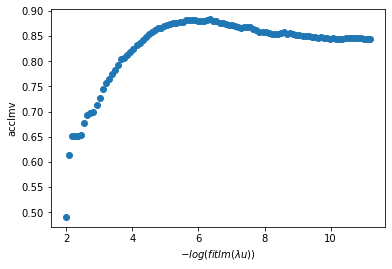

In [51]:
plt.scatter(-np.log(fitlm['lambdau']), acclmv)
plt.xlabel("$-log(fitlm(\lambda u))$")
plt.ylabel("acclmv");

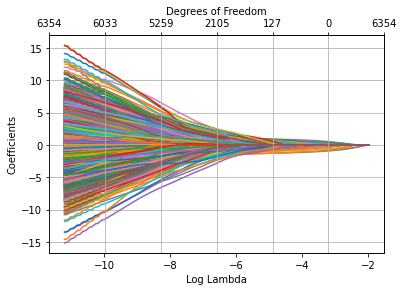

In [52]:
glmnetPlot(fitlm, xvar='lambda');

In [53]:
model = keras.models.Sequential(
    [
        layers.Dense(units=16, activation='relu'),
        layers.Dense(units=16, activation='relu'),
        layers.Dense(units=1, activation='sigmoid')
    ]
)

model.compile(
    loss='binary_crossentropy', 
    optimizer='rmsprop', 
    metrics='accuracy'
)

history = model.fit(x=x_train_1h.tocsr()[~ival_mask], 
                    y=y_train[~ival_mask], 
                    epochs=20, 
                    batch_size=512, 
                    validation_data=(x_train_1h.tocsr()[ival_mask], 
                                     y_train[ival_mask]),
                    verbose=0)

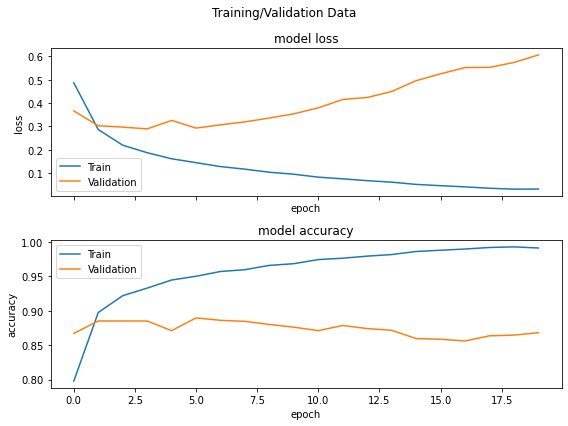

In [54]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))

fig.suptitle("Training/Validation Data")

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])

plt.tight_layout();

In [55]:
history2 = model.fit(x = x_train_1h.tocsr()[~ival_mask], 
                     y = y_train[~ival_mask], 
                     epochs=20, 
                     batch_size=512, 
                     validation_data=(x_test_1h.tocsr(), y_test),
                     verbose=0)

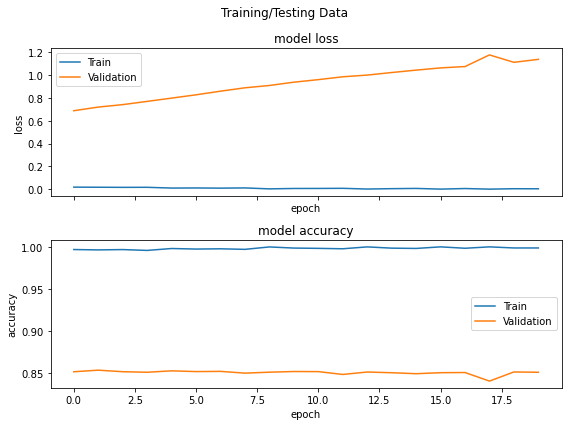

In [56]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))

fig.suptitle("Training/Testing Data")

ax[0].plot(history2.history['loss'])
ax[0].plot(history2.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history2.history['accuracy'])
ax[1].plot(history2.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])

plt.tight_layout();

# 10.9.6 Recurrent Neural Networks

In [57]:
max_features = 10_000
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

In [58]:
wc = []
for seq in x_train:
    seq_len = len(seq)
    wc.append(seq_len)
    
wc = np.array(wc)

np.median(wc)

178.0

In [59]:
sum(wc <= 500) / len(wc)

0.91568

In [60]:
maxlen = 500
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

In [61]:
def pad_sequences(data, maxlen):

    padded = []

    for row in data:
        row_len = len(row)
        abs_diff = abs(maxlen - row_len)
        if row_len < maxlen:
            padded.append(np.pad(array=row, pad_width=(abs_diff, 0)))
        else:
            padded.append(np.array(row[abs_diff:]))
           
    padded_array = np.array(padded)
    
    return padded_array

In [62]:
x_train = pad_sequences(x_train, maxlen)
x_test = pad_sequences(x_test, maxlen)

x_train.shape

(25000, 500)

In [63]:
x_test.shape

(25000, 500)

In [64]:
x_train[0, 489:500]

array([  16, 4472,  113,  103,   32,   15,   16, 5345,   19,  178,   32])

In [65]:
model = keras.models.Sequential(
    [
        layers.Embedding(input_dim = 10000, output_dim = 32),
        layers.LSTM(units = 32),
        layers.Dense(units = 1, activation = 'sigmoid')
    ]
)

In [66]:
model.compile(
    optimizer = 'rmsprop', 
    loss='binary_crossentropy', 
    metrics='accuracy'
)

history = model.fit(x = x_train, 
                    y = y_train,
                    epochs = 10, 
                    batch_size = 128,
                    validation_data = (x_test, y_test),
                    verbose=0)

In [67]:
predy = model.predict(x_test) > 0.5

np.mean(y_test == predy.flatten())

782/782 [==============================] - 21s 27ms/step


0.826

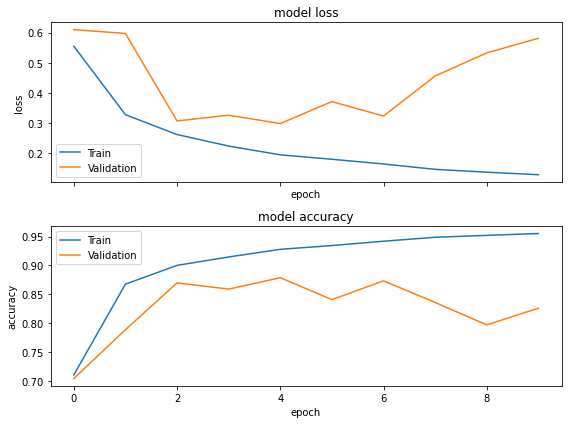

In [68]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (8,6))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])

plt.tight_layout();

## Time Series Prediction

In [69]:
data = robjects.r("""
library(ISLR2)
xdata <- NYSE[, c("DJ_return", "log_volume", "log_volatility")]
""")
with localconverter(robjects.default_converter + pandas2ri.converter):
    xdata = robjects.conversion.rpy2py(data)
    
data = robjects.r("""
library(ISLR2)
xdata <- NYSE[, "train"]
""")
istrain = np.array(data)

xdata = (xdata - xdata.mean()) / xdata.std()

In [70]:
def lagm(df, prefix, k=1):
    num_rows, num_cols = df.shape
    
    null_df = pd.DataFrame(np.ones(shape=(k, num_cols)) * np.nan,
                           columns = df.columns)
    
    padded_df = pd.concat([null_df, df[:-k]], ignore_index=True)
    #padded_df.index += 1
    
    for column in padded_df.columns:
        padded_df = padded_df.rename(columns={column: prefix + '_' + column})
    
    return padded_df

In [71]:
arframe = pd.concat(
    [
        xdata[['log_volume']].reset_index(drop=True),
        lagm(xdata, 'L1', 1), 
        lagm(xdata, 'L2', 2),
        lagm(xdata, 'L3', 3),
        lagm(xdata, 'L4', 4),
        lagm(xdata, 'L5', 5)
    ], axis=1
)

In [72]:
arframe = arframe[5:]
istrain = istrain[5:]

In [73]:
training_mask = istrain.astype(bool)

formula_string = formula_from_cols(arframe, 'log_volume')

armodel = smf.ols(formula=formula_string, data = sm.add_constant(arframe[training_mask]))

arfit = armodel.fit()

arpred = arfit.predict(arframe[~training_mask])
V_0 = arframe[~training_mask]['log_volume'].var()
1 - np.mean((arpred - arframe[~training_mask]['log_volume'])**2) / V_0

0.41322299369023163

In [74]:
data = robjects.r("""
library(ISLR2)
xdata <- NYSE[, 'day_of_week']
""")
day_df = pd.DataFrame(np.array(data), columns=['day'])

arframed = pd.concat([day_df[5:], arframe], axis=1)

formula_string = formula_from_cols(arframed, 'log_volume')

armodeld = smf.ols(formula=formula_string, data = sm.add_constant(arframed[training_mask]))

arfitd = armodeld.fit()

arpredd = arfitd.predict(arframed[~training_mask])
1 - np.mean((arpredd - arframed[~training_mask]['log_volume']) ** 2) / V_0

0.459861648721539

In [75]:
n = arframe.shape[0]
xrnn = pd.DataFrame(arframe.iloc[:,1:])
xrnn = np.array(xrnn)
xrnn = xrnn.reshape((n, 3, 5), order='F')
xrnn = xrnn[:,:,::-1]
xrnn = xrnn.transpose((0,2,1))
xrnn.shape

(6046, 5, 3)

In [76]:
model = keras.models.Sequential(
    [
        layers.SimpleRNN(units=12,
                         dropout=0.1,
                         recurrent_dropout=0.1),
        layers.Dense(units=1)
    ]
)

model.compile(optimizer='rmsprop', loss='mse')

In [77]:
history = model.fit(
    x = xrnn[training_mask, :, :],
    y = arframe[training_mask]['log_volume'],
    batch_size = 64, epochs = 200,
    validation_data = (xrnn[~training_mask, :, :], 
                       arframe[~training_mask]['log_volume']),
    verbose=0
)

kpred = model.predict(xrnn[~training_mask])
1 - np.mean((kpred.flatten() - arframe[~training_mask]['log_volume'])**2) / V_0

56/56 [==============================] - 0s 1ms/step


0.4163264046163502

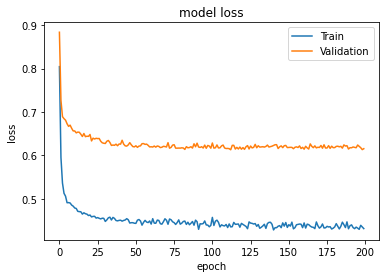

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation']);

In [79]:
x = patsy.dmatrix(formula_like = 'day + L1_DJ_return + L1_log_volume + L1_log_volatility + L2_DJ_return + L2_log_volume + L2_log_volatility + L3_DJ_return + L3_log_volume + L3_log_volatility + L4_DJ_return + L4_log_volume + L4_log_volatility + L5_DJ_return + L5_log_volume + L5_log_volatility - 1', data = arframed)

x.design_info.column_names

['day[fri]',
 'day[mon]',
 'day[thur]',
 'day[tues]',
 'day[wed]',
 'L1_DJ_return',
 'L1_log_volume',
 'L1_log_volatility',
 'L2_DJ_return',
 'L2_log_volume',
 'L2_log_volatility',
 'L3_DJ_return',
 'L3_log_volume',
 'L3_log_volatility',
 'L4_DJ_return',
 'L4_log_volume',
 'L4_log_volatility',
 'L5_DJ_return',
 'L5_log_volume',
 'L5_log_volatility']

In [80]:
arnnd = keras.models.Sequential(
    [
        layers.Dense(units = 32, activation = 'relu'),
        layers.Dropout(rate = 0.5),
        layers.Dense(units = 1)
    ]
)

arnnd.compile(loss = 'mse', optimizer = 'rmsprop')

history = arnnd.fit(
    x = x[training_mask],
    y = arframe[training_mask]['log_volume'],
    epochs = 100, batch_size = 32, 
    validation_data = [x[~training_mask], arframe[~training_mask]['log_volume']],
    verbose = 0
)

npred = arnnd.predict(x[~training_mask])
1 - np.mean((arframe[~training_mask]['log_volume'] - npred.flatten())**2) / V_0

56/56 [==============================] - 0s 798us/step


0.4650127534047914

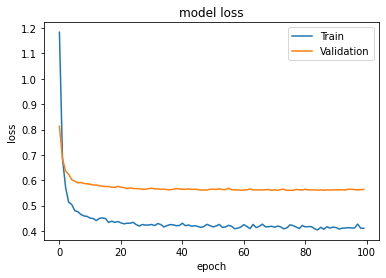

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation']);

The End